<a href="https://colab.research.google.com/github/ajag408/DeepGenerativeMusic/blob/main/RNNBaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: https://analyticsindiamag.com/a-hands-on-guide-to-automatic-music-generation-using-rnn/

In [1]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 39 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libqt5x11extras5 amd64 5.9.5-0ubuntu1 [8,596 B]
Get:5 http://archive.ubuntu.com/ubuntu bionic/uni

In [2]:
# !pip install fluidsynth version 1.2.4
!pip install -Iv https://pypi.python.org/packages/source/p/pyFluidSynth/pyFluidSynth-1.2.4.tar.gz#md5=60079310701d0b9298b65a8b6728ffcc

Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
Value for scheme.scripts does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/bin
sysconfig: /usr/bin
Value for scheme.data does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local
sysconfig: /usr
Additional context:
user = False
home

In [3]:
!pip install --upgrade pyfluidsynth

  Attempting uninstall: pyfluidsynth
    Found existing installation: pyFluidSynth 1.2.4
    Uninstalling pyFluidSynth-1.2.4:
      Successfully uninstalled pyFluidSynth-1.2.4


In [4]:
!pip install pretty_midi

     |████████████████████████████████| 5.6 MB 2.6 MB/s 
     |████████████████████████████████| 51 kB 3.3 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=24dd80d722d81863128cd33f0942ce7a3f6e1df311894c4bd72d2708b411cbc7
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [5]:
#install basic libraries
import collections
import datetime
import fluidsynth
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import pathlib
import glob

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple
#sets a global random seed
tf.random.set_seed(42)
np.random.seed(42)

In [6]:
#Get dataset Maestro-v2.0.0-midi
tf.keras.utils.get_file(
  'maestro-v2.0.0-midi.zip',
  origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
  extract=True,
  cache_dir='.', cache_subdir='data',
)

59252736/59243107 [==============================] - 1s 0us/step


'./data/maestro-v2.0.0-midi.zip'

In [7]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [8]:
#look at 1 file here out of 1282
sample_file = glob.glob(str(pathlib.Path('data/maestro-v2.0.0')/'**/*.mid*'))[1]
print(sample_file)

data/maestro-v2.0.0/2009/MIDI-Unprocessed_08_R2_2009_01_ORIG_MID--AUDIO_08_R2_2009_08_R2_2009_01_WAV.midi


In [9]:
#pretty_midi helps with extracting key info such as notes, instruments, etc. from Midi file so we 
import pretty_midi
file = pretty_midi.PrettyMIDI(sample_file)

In [10]:
#sampling rate of 16000 for audio playback
#trimmed file for 30 seconds

waveform = file.fluidsynth(fs=16000)
waveform_short = waveform[:30*16000]
display.Audio(waveform_short, rate=16000)

In [11]:
print('Number of instruments:', len(file.instruments))
print('Instrument name:', pretty_midi.program_to_instrument_name(file.instruments[0].program))

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [12]:
#extract each note
instrument = file.instruments[0]
for i, note in enumerate(instrument.notes[:15]):
  print(f'{i}: pitch={note.pitch}, note_name={pretty_midi.note_number_to_name(note.pitch)},'
        f' duration={note.end - note.start:.4f}')

0: pitch=59, note_name=B3, duration=1.5651
1: pitch=50, note_name=D3, duration=1.6367
2: pitch=43, note_name=G2, duration=2.2435
3: pitch=67, note_name=G4, duration=2.5807
4: pitch=71, note_name=B4, duration=2.6302
5: pitch=60, note_name=C4, duration=0.0482
6: pitch=50, note_name=D3, duration=0.0742
7: pitch=43, note_name=G2, duration=0.0807
8: pitch=66, note_name=F#4, duration=0.1549
9: pitch=69, note_name=A4, duration=0.2435
10: pitch=59, note_name=B3, duration=1.8190
11: pitch=50, note_name=D3, duration=2.1068
12: pitch=43, note_name=G2, duration=2.1328
13: pitch=67, note_name=G4, duration=2.4596
14: pitch=71, note_name=B4, duration=2.5130


In [13]:
#make notes available in Pandas DataFrame

def midi_to_df(files: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(files)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    #step is the time elapsed from the previous note
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [15]:
music_df = midi_to_df(sample_file)
music_df.head(10)

,pitch,start,end,step,duration
0,50,0.959635,2.596354,0.000000,1.636719
1,71,0.962240,3.592448,0.002604,2.630208
2,59,0.970052,2.535156,0.007812,1.565104
3,67,0.972656,3.553385,0.002604,2.580729
4,43,0.979167,3.222656,0.006510,2.243490
5,69,3.587240,3.830729,2.608073,0.243490
6,66,3.593750,3.748698,0.006510,0.154948
7,60,3.595052,3.643229,0.001302,0.048177
8,50,3.601562,3.675781,0.006510,0.074219
9,43,3.605469,3.686198,0.003906,0.080729


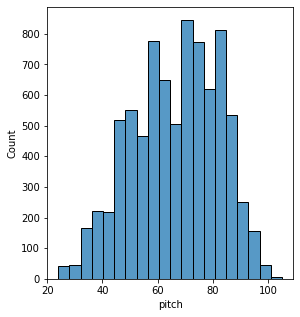

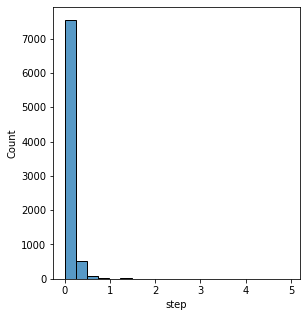

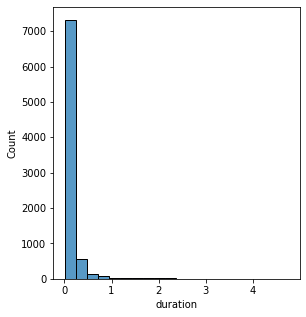

In [ ]:
#some analytics
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=[15, 5])
plt.subplot(1, 3, 1)
sns.histplot(music_df, x="pitch", bins=20)

plt.figure(figsize=[15, 5])
plt.subplot(1, 3, 1)
sns.histplot(music_df, x="step", bins=20)

plt.figure(figsize=[15, 5])
plt.subplot(1, 3, 1)
sns.histplot(music_df, x="duration", bins=20)

In [21]:
#starting to create tensor
#only uses first 5 files here
all_notes = []
counter = 1
for f in filenames[:100]:
  print("on file: ", counter)
  counter += 1
  notes = midi_to_df(f)
  all_notes.append(notes)

notes_df = pd.concat(all_notes)

on file:  1
on file:  2
on file:  3
on file:  4
on file:  5
on file:  6
on file:  7
on file:  8
on file:  9
on file:  10
on file:  11
on file:  12
on file:  13
on file:  14
on file:  15
on file:  16
on file:  17
on file:  18
on file:  19
on file:  20
on file:  21
on file:  22
on file:  23
on file:  24
on file:  25
on file:  26
on file:  27
on file:  28
on file:  29
on file:  30
on file:  31
on file:  32
on file:  33
on file:  34
on file:  35
on file:  36
on file:  37
on file:  38
on file:  39
on file:  40
on file:  41
on file:  42
on file:  43
on file:  44
on file:  45
on file:  46
on file:  47
on file:  48
on file:  49
on file:  50
on file:  51
on file:  52
on file:  53
on file:  54
on file:  55
on file:  56
on file:  57
on file:  58
on file:  59
on file:  60
on file:  61
on file:  62
on file:  63
on file:  64
on file:  65
on file:  66
on file:  67
on file:  68
on file:  69
on file:  70
on file:  71
on file:  72
on file:  73
on file:  74
on file:  75
on file:  76
on file:  77
on file:

In [22]:
print(notes_df)

      pitch       start         end      step  duration
0        69    0.997396    3.449219  0.000000  2.451823
1        64    1.002604    5.505208  0.005208  4.502604
2        58    1.035156    5.828125  0.032552  4.792969
3        76    1.682292    1.753906  0.647135  0.071615
4        78    1.748698    1.809896  0.066406  0.061198
...     ...         ...         ...       ...       ...
4201     60  334.510417  334.593750  0.019531  0.083333
4202     80  334.510417  335.539062  0.000000  1.028646
4203     51  334.536458  334.597656  0.026042  0.061198
4204     39  336.055990  336.101562  1.519531  0.045573
4205     32  336.768229  336.822917  0.712240  0.054688

[608691 rows x 5 columns]


In [23]:
notes_df.head(10)

,pitch,start,end,step,duration
0,69,0.997396,3.449219,0.000000,2.451823
1,64,1.002604,5.505208,0.005208,4.502604
2,58,1.035156,5.828125,0.032552,4.792969
3,76,1.682292,1.753906,0.647135,0.071615
4,78,1.748698,1.809896,0.066406,0.061198
5,81,1.822917,1.885417,0.074219,0.062500
6,84,1.897135,2.589844,0.074219,0.692708
7,72,2.458333,2.488281,0.561198,0.029948
8,66,3.003906,5.516927,0.545573,2.513021
9,73,3.040365,3.773438,0.036458,0.733073


In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([notes_df[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec


TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
#shape (25,3)? model takes 25 notes as input? article says (100,1)
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
batch_size = 64
buffer_size = len(notes_df) - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
#loss function that makes model produce positive values
def mse(y_true: tf.Tensor, y_pred: tf.Tensor):
  mser = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mser + positive_pressure)

In [ ]:
#creating model
inputs = tf.keras.Input((seq_length, 3))
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse,
      'duration': mse,
}


model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.5))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [ ]:
#?
print(model.evaluate(train_ds, return_dict=True))

562/562 [==============================] - 18s 20ms/step - loss: 5.0460 - duration_loss: 0.1508 - pitch_loss: 4.8479 - step_loss: 0.0473
{'loss': 5.045965194702148, 'duration_loss': 0.15079011023044586, 'pitch_loss': 4.8478546142578125, 'step_loss': 0.04732286557555199}


In [ ]:
#next two cells: training model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=50,
    callbacks=callbacks,
)

Epoch 1/50
562/562 [==============================] - 38s 64ms/step - loss: 49.1318 - duration_loss: 11.6769 - pitch_loss: 26.4724 - step_loss: 10.9825
Epoch 2/50
562/562 [==============================] - 24s 43ms/step - loss: 30.6867 - duration_loss: 4.0687 - pitch_loss: 22.2182 - step_loss: 4.3998
Epoch 3/50
562/562 [==============================] - 24s 43ms/step - loss: 34.1342 - duration_loss: 8.6000 - pitch_loss: 16.6563 - step_loss: 8.8779
Epoch 4/50
562/562 [==============================] - 27s 49ms/step - loss: 34.6280 - duration_loss: 8.4418 - pitch_loss: 17.3242 - step_loss: 8.8620
Epoch 5/50
562/562 [==============================] - 28s 51ms/step - loss: 30.6577 - duration_loss: 5.7512 - pitch_loss: 17.2167 - step_loss: 7.6898
Epoch 6/50
562/562 [==============================] - 27s 48ms/step - loss: 27.4919 - duration_loss: 2.6555 - pitch_loss: 17.3691 - step_loss: 7.4673
Epoch 7/50
562/562 [==============================] - 24s 42ms/step - loss: 27.6863 - duration_los

In [ ]:
def predict_next_note(notes: np.ndarray, keras_model: tf.keras.Model, temperature: float = 1.0) -> int:
  
  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([music_df[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [ ]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,67,2.890824,3.602288,2.890824,6.493112
1,68,4.570398,1.019113,7.461222,8.480335
2,60,5.178192,0.436264,12.639414,13.075678
3,68,5.289979,0.359707,17.929394,18.289101
4,68,5.284190,0.334628,23.213583,23.548211
5,68,5.285931,0.332958,28.499514,28.832473
6,60,5.286167,0.332732,33.785681,34.118413
7,60,5.302938,0.344181,39.088619,39.432800
8,68,5.305732,0.346089,44.394351,44.740440
9,60,5.286205,0.332698,49.680556,50.013254


In [ ]:
def df_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  file = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  file.instruments.append(instrument)
  file.write(out_file)
  return file

In [ ]:
generated = df_to_midi(
    music_df, out_file='generated.midi', instrument_name=instrument_name)

In [ ]:
waveform = generated.fluidsynth(fs=16000)
waveform_short = waveform[:30*16000]
display.Audio(waveform_short, rate=16000)